In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import os
import matplotlib.image as img
import tqdm
import matplotlib.pyplot as plt 
from vae import Basic_VAE
from encoder import Encoder
from decoder import Decoder
from torch.utils.data import DataLoader, TensorDataset

#### Create Dataset


In [31]:
cats = []
directory = "data/cats"
count = 0

for catpic in os.listdir(directory):
    if count < 3000:
        # read from image and convert to tensor
        im = torch.tensor(img.imread(os.path.join(directory, catpic))).float()
        # permute to (channels, height, width) for conv2d layer
        im = torch.permute(im, (2, 0, 1))
        # normalize to range between -1 and 1
        im = im / 128 - 1
        cats.append(im)
        count += 1
    else:
        break
cats = torch.stack(cats)
print(cats.shape)

torch.Size([3000, 3, 64, 64])


#### Test/Training/Validation Split


In [32]:
# Split the data into what we use for testing and not testing
training_test_split = 0.75
training_test_cutoff = int(cats.shape[0] * training_test_split + 1)
random_perm = torch.randperm(cats.shape[0])
not_test_tensor = cats[:training_test_cutoff]
testing_tensor = cats[training_test_cutoff:]
# Split the data into what we use for training and cross validation
training_cv_split = 0.8
training_cv_cutoff = int(not_test_tensor.shape[0] * training_cv_split)
training_tensor = not_test_tensor[:training_cv_cutoff]
cv_tensor = not_test_tensor[training_cv_cutoff:]
print(training_tensor.shape)
print(cv_tensor.shape)
print(testing_tensor.shape)

torch.Size([1800, 3, 64, 64])
torch.Size([451, 3, 64, 64])
torch.Size([749, 3, 64, 64])


#### Choose Hyperparameters and Build Model


In [33]:
from vae import Basic_VAE

hidden_dims = [16, 32, 64, 128]
latent_dim = 64
in_dim = 3
model = Basic_VAE(in_dim, hidden_dims, latent_dim)
# encoder = Encoder(in_dim, hidden_dims, latent_dim) for testing
# decoder = Decoder(latent_dim, hidden_dims) for testing

In [34]:
# # Testing the model
model.forward(training_tensor)
# # Code to test out the encoder & decoder
# mu, log_var = encoder.forward(training_tensor)
# print("mu: ", mu.shape)
# print("log_var: ", log_var.shape)

# reconstructed_img = decoder.forward(mu, log_var)

[tensor([[[[ 4.4432e-02,  3.8147e-01, -1.0840e-01,  ..., -1.9395e-01,
             1.1578e-01, -6.2665e-02],
           [ 3.5675e-02,  5.2581e-01,  3.2898e-01,  ..., -4.1034e-01,
             2.8723e-01, -1.8746e-01],
           [ 3.0575e-01,  6.6601e-01,  7.8123e-01,  ...,  6.3030e-01,
             5.4253e-01,  1.6046e-01],
           ...,
           [ 4.9571e-02, -1.2899e-01,  2.9603e-01,  ...,  5.4094e-02,
            -1.0483e-01,  1.0579e-01],
           [ 2.6549e-01,  4.2650e-01,  5.6576e-01,  ..., -2.0252e-01,
             6.4802e-03,  1.1686e-01],
           [-1.8860e-02, -1.4903e-01, -6.5189e-02,  ...,  1.1229e-01,
             1.1576e-01, -2.5140e-02]],
 
          [[-1.1834e-01,  3.4773e-02,  2.8212e-01,  ...,  2.7037e-01,
             7.3825e-02,  1.0475e-02],
           [-4.0073e-01,  4.5983e-01, -5.9338e-01,  ..., -5.9905e-01,
             1.4719e-01, -2.8182e-01],
           [-1.1318e-01,  6.9378e-01, -4.7710e-01,  ...,  2.3735e-01,
            -1.9829e-01, -2.2894e-02],


#### Implement Loss Function


In [35]:
def loss_function(reconstructed_img, input_img, mu, log_var, kld_weight=2):
    # print("reconstructed_img: ", reconstructed_img.shape)
    # print("input_img: ", input_img.shape)
    img_loss = F.mse_loss(reconstructed_img, input_img)
    # article on calculating kl divergence between 2 gaussians:
    # https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7
    kld_loss = torch.mean(
        torch.sum(-log_var + (log_var.exp() ** 2 + mu**2) / 2 - 1 / 2)
        
    )
    # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))
    kld_loss *= kld_weight

    return img_loss + kld_loss

#### Implement Gradient Descent


In [36]:
def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000, batch_size=32):
    # only really need x or y, they are the same thing
    optimizer = optim.AdamW(model.parameters(), lr)

    losses = []
    valid_losses = []

    train_dataset = TensorDataset(x, y)
    train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TensorDataset(xvalid, yvalid)
    valid_batches = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for _ in tqdm.trange(steps):
        model.train()
        total_loss = 0

        for input_batch, label_batch in train_batches:
            reconstructed_img, mu, log_var = model(input_batch)
            # y is the original image I think? yeah
            loss = loss_func(reconstructed_img, label_batch, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            optimizer.zero_grad()
        mean_loss = total_loss/len(train_batches)
        losses.append(mean_loss)

        model.eval()
        total_valid_loss = 0
        for input_valid_batch, label_valid_batch in valid_batches:
            reconstructed_img, mu, log_var = model(input_valid_batch)
            valid_loss = loss_func(reconstructed_img, label_valid_batch, mu, log_var)
            total_valid_loss += valid_loss.detach()
        mean_valid_loss = total_valid_loss/len(valid_batches)
        valid_losses.append(mean_valid_loss)

    print(f"Final training loss: {losses[-1]}")

    return losses, valid_losses

In [37]:
losses, valid_losses = gradient_descent(
    model, loss_function, training_tensor, training_tensor, cv_tensor, cv_tensor, steps=500, lr = 0.001
)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [49:41<00:00,  5.96s/it]

Final training loss: 0.24581536833654372


In [40]:
torch.save(model.state_dict(), "saved_model")

torch.Size([1, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


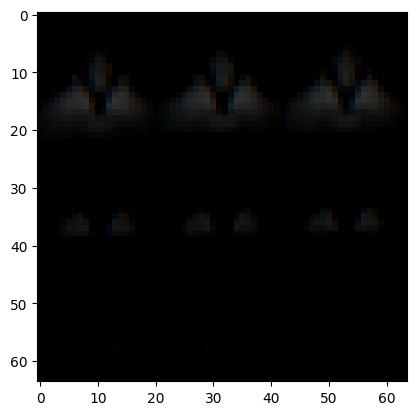

In [41]:
# after we've trained, we use the decoder to generate new images
# we assume a normal distribution over our latent space
# so we sample from that distribution and feed it into the decoder
img = model.sample_img()
img = img.view(64, 64, 3)
img = img.detach().numpy()
plt.imshow(img)